In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import torch as t
from utils.config import opt
from model import FasterRCNNVGG16
from trainer import FasterRCNNTrainer
from data.util import  read_image
from utils.vis_tool import vis_bbox
from utils import array_tool as at
import numpy as np
import pickle

%matplotlib inline

/home/tadenoud/Git/simple-faster-rcnn-pytorch/utils/vis_tool.py:8: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('Agg')


In [2]:
faster_rcnn = FasterRCNNVGG16()
trainer = FasterRCNNTrainer(faster_rcnn).cuda()

# Load model trained with caffe pretrained model

In [3]:
trainer.load('./checkpoints/fasterrcnn_02202207_0.6666273688828848')
opt.caffe_pretrain=True # this model was trained from caffe-pretrained model

In [4]:
img = read_image('misc/demo.jpg')
img = t.from_numpy(img)[None]

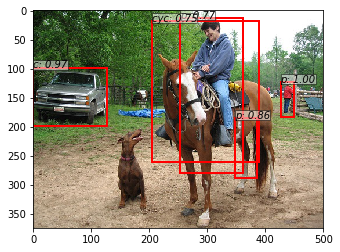

In [5]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(img,visualize=True)
vis_bbox(at.tonumpy(img[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

# Display a Kitti image

In [6]:
import os

# dataset_dir = '/media/tadenoud/DATADisk/datasets/kitti_2d'  # School comp
dataset_dir = '/home/tadenoud/Documents/kitti' # Laptop

img_paths = [
    os.path.join(dataset_dir, 'training/image_2/005009.png'),
    os.path.join(dataset_dir, 'training/image_2/005010.png')
]

imgs = np.array([read_image(p) for p in img_paths])

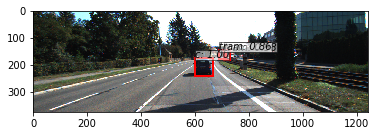

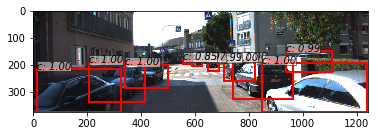

In [7]:
_bboxes, _labels, _scores = trainer.faster_rcnn.predict(imgs,visualize=True)
vis_bbox(at.tonumpy(imgs[0]),
         at.tonumpy(_bboxes[0]),
         at.tonumpy(_labels[0]).reshape(-1),
         at.tonumpy(_scores[0]).reshape(-1))

vis_bbox(at.tonumpy(imgs[1]),
         at.tonumpy(_bboxes[1]),
         at.tonumpy(_labels[1]).reshape(-1),
         at.tonumpy(_scores[1]).reshape(-1))

In [8]:
# Read a Kitti GT label
from data.util import read_bbox

img_label_paths = [
    os.path.join(dataset_dir, 'training/label_2/005009.txt'),
    os.path.join(dataset_dir, 'training/label_2/005010.txt')
]

gt = np.array([read_bbox(p, ignore_dontcare=True) for p in img_label_paths]) 
gt_bboxes = gt[:,0]
gt_labels = gt[:,1]

# Train mahalanobis features with entire training dataset

In [9]:
from utils.config import opt
from data.dataset import Dataset, TestDataset
from torch.utils.data import DataLoader


print('load data') 
dataset = Dataset(opt)
dataloader = DataLoader(dataset,
                        batch_size=1,
                        shuffle=False, \
                        # pin_memory=True,
                        num_workers=opt.num_workers)

# mahal_means, mahal_cov = trainer.faster_rcnn.train_ood(dataloader)

# with open('kitti_features.pickle', 'wb') as f:
#     pickle.dump(trainer.faster_rcnn.features, f)
    
# with open('mahal_means.pickle', 'wb') as f:
#     pickle.dump(mahal_means, f)

# with open('mahal_cov.pickle', 'wb') as f:
#     pickle.dump(mahal_cov, f)

# with open('inv_mahal_cov.pickle', 'wb') as f:
#     pickle.dump(trainer.faster_rcnn.inv_mahal_cov, f)

with open('kitti_features.pickle', 'rb') as f:
    trainer.faster_rcnn.features = pickle.load(f)
    
with open('mahal_means.pickle', 'rb') as f:
    mahal_means = pickle.load(f)
    trainer.faster_rcnn.mahal_means = mahal_means
        
with open('mahal_cov.pickle', 'rb') as f:
    mahal_cov = pickle.load(f)
    trainer.faster_rcnn.mahal_cov = mahal_cov
    
with open('inv_mahal_cov.pickle', 'rb') as f:
    inv_mahal_cov = pickle.load(f)
    trainer.faster_rcnn.inv_mahal_cov = inv_mahal_cov

load data


In [10]:
trainer.faster_rcnn.inv_mahal_cov

array([[ 3.22996219e+03, -1.22012931e+02, -1.92700395e+01, ...,
        -8.16444614e+01, -1.00169407e+00,  1.43790446e+01],
       [-1.22012931e+02,  2.84540663e+03, -4.90195160e+00, ...,
         6.00474590e+01, -4.41628009e+01, -3.29130517e+01],
       [-1.92700395e+01, -4.90195160e+00,  1.87434119e+03, ...,
        -2.53597710e+01,  7.16879143e+00,  6.97982280e+01],
       ...,
       [-8.16444614e+01,  6.00474590e+01, -2.53597710e+01, ...,
         4.58822753e+03, -6.70025825e+01,  5.50594323e+01],
       [-1.00169407e+00, -4.41628009e+01,  7.16879142e+00, ...,
        -6.70025825e+01,  2.81189016e+03,  1.80790945e+01],
       [ 1.43790446e+01, -3.29130517e+01,  6.97982280e+01, ...,
         5.50594323e+01,  1.80790945e+01,  1.83965386e+03]])

In [11]:
# from tqdm import tqdm
# gt_labels = []

# for ii, (img, bbox_, label_, scale) in tqdm(enumerate(dataloader), total=3711):
#     gt_labels.append(at.tonumpy(label_[0]))

#     if ii == 3711:
#         break
        
# gt_labels = np.concatenate(gt_labels, axis=0)

# with open('kitti_labels.pickle', 'wb') as f:
#     pickle.dump(gt_labels, f)

with open('kitti_labels.pickle', 'rb') as f:
    gt_labels = pickle.load(f)

In [12]:
VOC_BBOX_LABEL_NAMES = (
    'car',
    'van',
    'bus',
    'truck',
    'tram',
    'person',
    'person_sitting',
    'cyclist',
    'motorbike',
    'misc'
    # 'dontcare
)

for j in range(10):
    print(VOC_BBOX_LABEL_NAMES[j], "count:", sum([i == j for i in gt_labels]))

car count: 14081
van count: 1468
bus count: 0
truck count: 529
tram count: 265
person count: 2272
person_sitting count: 117
cyclist count: 837
motorbike count: 0
misc count: 497


In [13]:
print("Zeros in cov matrix:", (lambda a, b: a * b)(*mahal_cov.shape) - np.count_nonzero(mahal_cov))

Zeros in cov matrix: 106327


# Visualize features using t-SNE

In [14]:
from time import time
from sklearn.manifold import TSNE

# print("Computing t-SNE embedding")
# tsne = TSNE(n_components=2, init='pca', random_state=0, perplexity=20)
# t0 = time()
# X_tsne = tsne.fit_transform(trainer.faster_rcnn.features)
# t1 = time()

In [15]:
# with open("tsne_features.pickle", "wb") as f:
#     pickle.dump(X_tsne, f)

with open("tsne_features.pickle", "rb") as f:
    X_tsne = pickle.load(f)

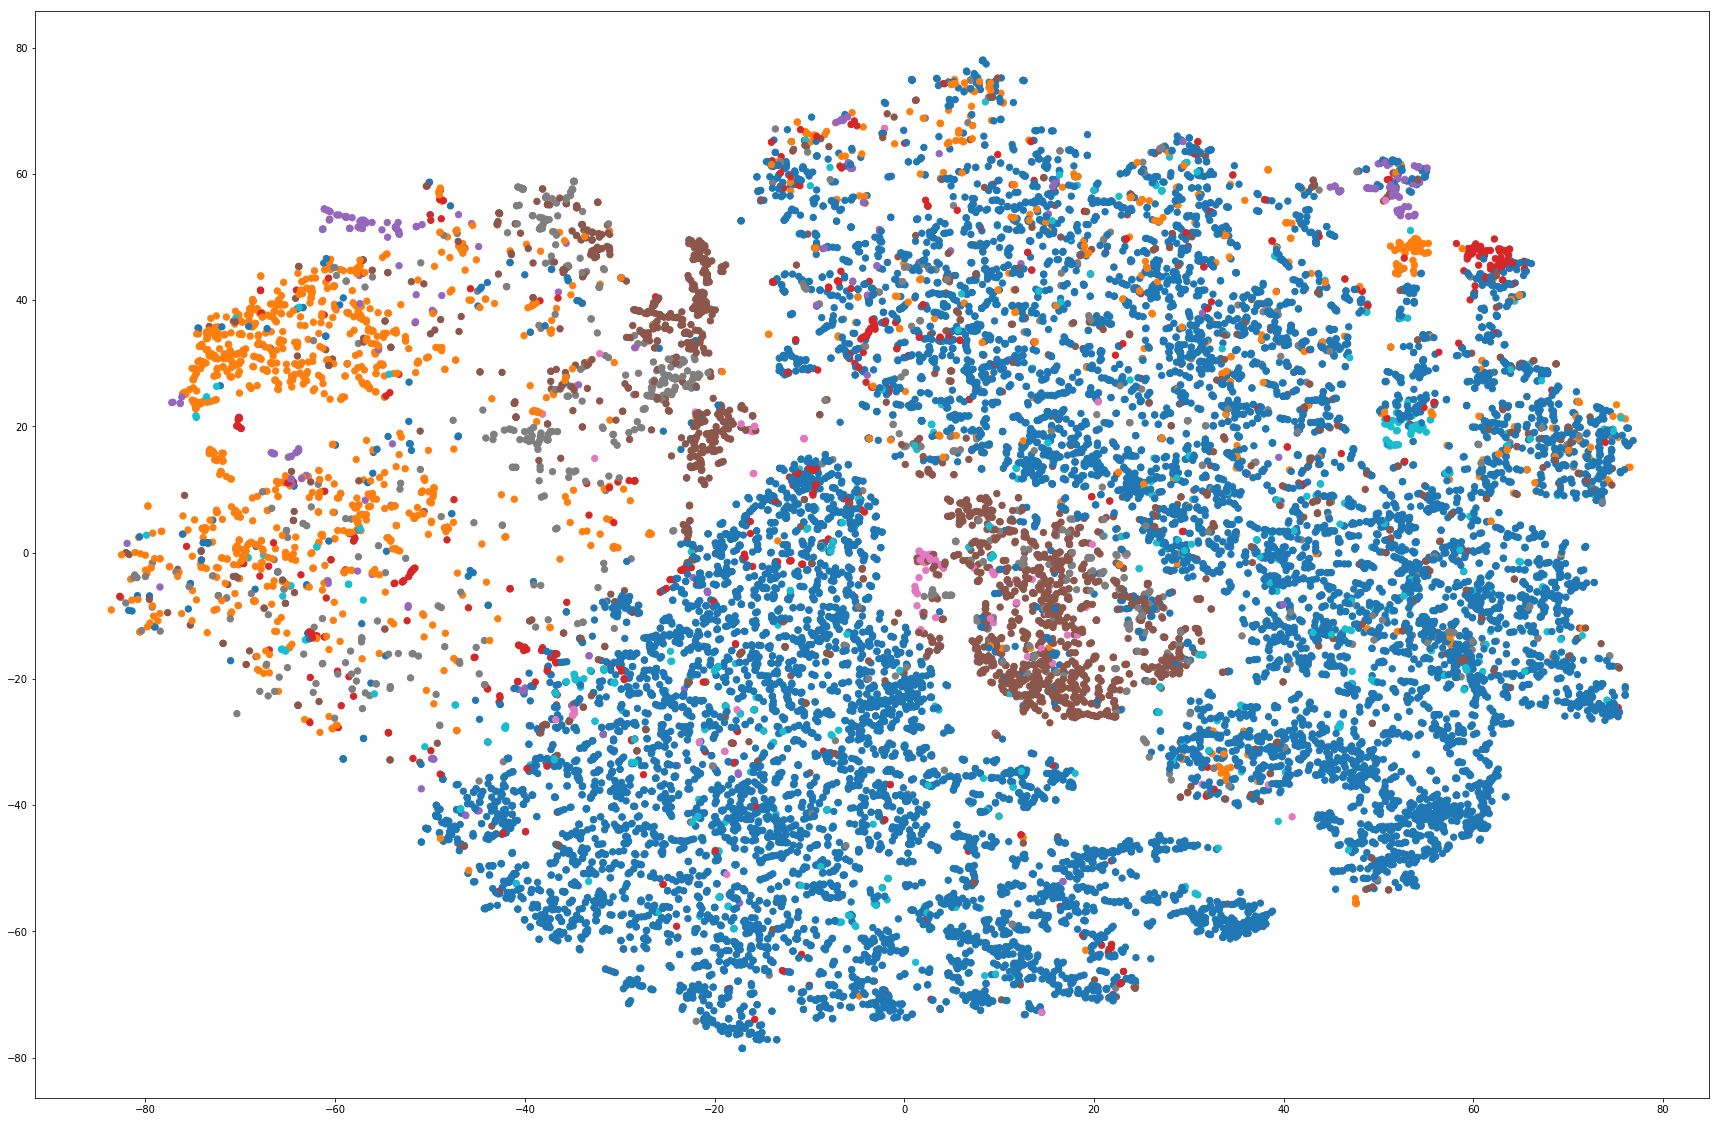

In [16]:
import matplotlib.pyplot as plt

mask = (gt_labels != -1)
plt.figure(figsize=(30, 20))
plt.scatter(X_tsne[:,0][mask], X_tsne[:,1][mask], c=gt_labels[mask], s=40, cmap=plt.cm.get_cmap('tab10'))
plt.show()

In [17]:
# VOC_BBOX_LABEL_NAMES = (
#     'car': blue,
#     'van': orange,
#     'bus': green,
#     'truck': red,
#     'tram': purple,
#     'person': brown,
#     'person_sitting': pink,
#     'cyclist': gray,
#     'motorbike': yellow,
#     'misc': cyan
#     # 'dontcare
# )

# Predict class using features

In [18]:
# Evaluate baseline softmax method
from train import eval, eval_mahal

print('load data') 
test_dataset = TestDataset(opt)
test_dataloader = DataLoader(test_dataset,
                             batch_size=1,
                             shuffle=False,
                             pin_memory=True,
                             num_workers=opt.num_workers)

# baseline_result = eval(test_dataloader, trainer.faster_rcnn, test_num=3769)
# with open("baseline_results.pickle", 'wb') as f:
#     pickle.dump(baseline_result, f)
    
with open("baseline_results.pickle", 'rb') as f:
    baseline_result = pickle.load(f)
    
print(baseline_result)

load data
{'ap': array([0.80864394, 0.80424119,        nan, 0.90356361, 0.90653619,
       0.60343095, 0.61519067, 0.6914124 ,        nan, 0.77499757]), 'map': 0.7635020654888013}


/home/tadenoud/Git/simple-faster-rcnn-pytorch/train.py:26: UserWarning: matplotlib.pyplot as already been imported, this call will have no effect.
  matplotlib.use('agg')


In [ ]:
# Evaluate mahalanobis distance method

mahal_result = eval_mahal(test_dataloader, trainer.faster_rcnn, test_num=3769)

with open("mahal_result.pickle", "wb") as f:
    pickle.dump(mahal_result, f)
    
# with open("mahal_result.pickle", "rb") as f:
#     mahal_result = pickle.load(f)
    
print(mahal_result)

 28%|██▊       | 1047/3769 [13:44<35:42,  1.27it/s]